In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the Public Debt (Target) and Export datasets
df_debt = pd.read_csv('/content/drive/MyDrive/Capstone Data/2011-2019/Cleaned_Public_Debt_2011-2019.csv')
df_export = pd.read_csv('/content/drive/MyDrive/Capstone Data/2011-2019/Cleaned_Export_2011-2019.csv')

In [ ]:
df_export.head()

,Country,Ccode,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Australia,AUS,0.318326,0.109363,-0.052790,-0.017240,-0.124246,-0.141949,0.211077,0.109423,0.076360
1,Austria,AUT,0.158138,-0.051182,0.040344,0.027430,-0.141950,0.023026,0.087223,0.118385,-0.017806
2,Belgium,BEL,0.158923,-0.057216,0.036586,0.032813,-0.159412,0.051678,0.106921,0.083810,-0.017006
3,Canada,CAN,0.166256,0.008726,0.009269,0.023163,-0.134946,-0.029030,0.077722,0.075085,0.011518
4,Switzerland,CHE,0.225162,-0.022008,0.094003,-0.067334,-0.066678,0.037440,0.003524,0.061453,-0.013344


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# List of European OECD countries (Geographic)
european_oecd_countries = [
    "Austria", "Belgium", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Germany",
    "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg",
    "Netherlands", "Norway", "Poland", "Portugal", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Switzerland", "United Kingdom"]

# List of non-European OECD countries
non_european_oecd_countries = [
    "Australia", "Canada", "Chile", "Colombia", "Israel", "Japan", "Korea", "Mexico", "New Zealand", "Turkey", "United States"]

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_export, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_export = df_export.melt(id_vars=["Country"], var_name="Year", value_name="Exports")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_export, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Exports' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Exports'] = pd.to_numeric(df_long['Exports'], errors='coerce')

# Filter to 2014-2019
df_2014_2019 = df_long[df_long["Year"].between(2014, 2019)].dropna(subset=["Public_Debt", "Exports"]).copy()

# IQR function with country tracking (only for Exports)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Exports and track removed countries
df_2014_2019_clean, removed_countries_exports = drop_outliers_iqr(df_2014_2019, "Exports")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_exports if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_exports if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2014_2019_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(european_oecd_countries)]
df_2014_2019_non_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-exports ratio (average over 2014-2019)
df_2014_2019_european['Debt_to_Exports'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Exports"]
median_ratio = df_2014_2019_european.groupby('Country')['Debt_to_Exports'].mean().median()
european_ratios = df_2014_2019_european.groupby('Country')['Debt_to_Exports'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(positive_european)]
df_negative_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Exports"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Positive European OECD countries (High Debt-to-Exports) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Exports"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2014-2019):")
    print(f"Coefficient (Exports): {model_pos.params['Exports']:.3f}, p-value: {model_pos.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Exports"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Negative European OECD countries (Low Debt-to-Exports) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Exports"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2014-2019):")
    print(f"Coefficient (Exports): {model_neg.params['Exports']:.3f}, p-value: {model_neg.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2014_2019_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2014_2019_non_european["Public_Debt"], df_2014_2019_non_european["Exports"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for non-European OECD countries after removing outliers in Exports: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2014_2019_non_european["Exports"]
    y_non_eu = df_2014_2019_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2014-2019):")
    print(f"Coefficient (Exports): {model_non_eu.params['Exports']:.3f}, p-value: {model_non_eu.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2014-2019 (after removing outliers in Exports)
if len(df_2014_2019_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2014_2019_clean["Public_Debt"], df_2014_2019_clean["Exports"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Exports (2014-2019) after removing outliers in Exports: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2014_2019_clean["Exports"]
    y_overall = df_2014_2019_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2014-2019):")
    print(f"Coefficient (Exports): {model_overall.params['Exports']:.3f}, p-value: {model_overall.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Exports:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Exports:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Exports):", positive_european)
print("Negative European OECD countries (Low Debt-to-Exports):", negative_european)

2014-2019 Correlation for Positive European OECD countries (High Debt-to-Exports) after removing outliers: -0.002, p-value: 0.986 (Not Significant)

Linear Regression (Positive European OECD, 2014-2019):
Coefficient (Exports): -0.001, p-value: 0.986
R-squared: 0.000
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                 0.0002928
Date:                Fri, 11 Apr 2025   Prob (F-statistic):              0.986
Time:                        21:22:28   Log-Likelihood:                 99.447
No. Observations:                  77   AIC:                            -194.9
Df Residuals:                      75   BIC:                            -190.2
Df Model:                           1                                         
Covariance Type:      

<ipython-input-5-49fbeddbae6a>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014_2019_european['Debt_to_Exports'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Exports"]


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_export, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_export = df_export.melt(id_vars=["Country"], var_name="Year", value_name="Exports")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_export, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Exports' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Exports'] = pd.to_numeric(df_long['Exports'], errors='coerce')

# Filter to 2011-2013
df_2011_2013 = df_long[df_long["Year"].between(2011, 2013)].dropna(subset=["Public_Debt", "Exports"]).copy()

# IQR function with country tracking (only for Exports)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Exports and track removed countries
df_2011_2013_clean, removed_countries_exports = drop_outliers_iqr(df_2011_2013, "Exports")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_exports if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_exports if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2011_2013_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(european_oecd_countries)]
df_2011_2013_non_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-exports ratio (average over 2011-2013)
df_2011_2013_european['Debt_to_Exports'] = df_2011_2013_european["Public_Debt"] / df_2011_2013_european["Exports"]
median_ratio = df_2011_2013_european.groupby('Country')['Debt_to_Exports'].mean().median()
european_ratios = df_2011_2013_european.groupby('Country')['Debt_to_Exports'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(positive_european)]
df_negative_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Exports"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Positive European OECD countries (High Debt-to-Exports) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Exports"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2011-2013):")
    print(f"Coefficient (Exports): {model_pos.params['Exports']:.3f}, p-value: {model_pos.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Exports"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Negative European OECD countries (Low Debt-to-Exports) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Exports"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2011-2013):")
    print(f"Coefficient (Exports): {model_neg.params['Exports']:.3f}, p-value: {model_neg.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2011_2013_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2011_2013_non_european["Public_Debt"], df_2011_2013_non_european["Exports"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for non-European OECD countries after removing outliers in Exports: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2011_2013_non_european["Exports"]
    y_non_eu = df_2011_2013_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2011-2013):")
    print(f"Coefficient (Exports): {model_non_eu.params['Exports']:.3f}, p-value: {model_non_eu.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2011-2013 (after removing outliers in Exports)
if len(df_2011_2013_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2011_2013_clean["Public_Debt"], df_2011_2013_clean["Exports"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Exports (2011-2013) after removing outliers in Exports: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2011_2013_clean["Exports"]
    y_overall = df_2011_2013_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2011-2013):")
    print(f"Coefficient (Exports): {model_overall.params['Exports']:.3f}, p-value: {model_overall.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Exports:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Exports:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Exports):", positive_european)
print("Negative European OECD countries (Low Debt-to-Exports):", negative_european)

<ipython-input-5-9ddb4b3bbd15>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2011_2013_european['Debt_to_Exports'] = df_2011_2013_european["Public_Debt"] / df_2011_2013_european["Exports"]


2011-2013 Correlation for Positive European OECD countries (High Debt-to-Exports) after removing outliers: -0.043, p-value: 0.793 (Not Significant)

Linear Regression (Positive European OECD, 2011-2013):
Coefficient (Exports): -0.045, p-value: 0.793
R-squared: 0.002
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                   0.06953
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.793
Time:                        19:47:09   Log-Likelihood:                 36.082
No. Observations:                  39   AIC:                            -68.16
Df Residuals:                      37   BIC:                            -64.84
Df Model:                           1                                         
Covariance Type:      

In [ ]:
#Import the cleaned GDP YOY dataset
df_GDP = pd.read_csv('/content/drive/MyDrive/Capstone Data/2011-2019/Cleaned_National_GDP_2011-2019.csv')

In [ ]:
df_GDP.head()

,Country,CCode,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Australia,AUS,0.217391,0.107143,0.019355,-0.069620,-0.081633,-0.103704,0.099174,0.075188,-0.027972
1,Austria,AUT,0.100000,-0.051282,0.049140,0.028103,-0.134396,0.036842,0.053299,0.091566,-0.022075
2,Belgium,BEL,0.093361,-0.055028,0.052209,0.026718,-0.143123,0.028200,0.056962,0.083832,-0.011050
3,Canada,CAN,0.104938,0.022346,0.010929,-0.021622,-0.138122,-0.019231,0.078431,0.048485,0.005780
4,Switzerland,CHE,0.195326,-0.041899,0.029155,0.029745,-0.045392,-0.008646,0.010174,0.044604,-0.006887


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_GDP, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_GDP = df_GDP.melt(id_vars=["Country"], var_name="Year", value_name="GDP")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_GDP, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'GDP' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['GDP'] = pd.to_numeric(df_long['GDP'], errors='coerce')

# Filter to 2014-2019
df_2014_2019 = df_long[df_long["Year"].between(2014, 2019)].dropna(subset=["Public_Debt", "GDP"]).copy()

# IQR function with country tracking (only for GDP)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for GDP and track removed countries
df_2014_2019_clean, removed_countries_GDP = drop_outliers_iqr(df_2014_2019, "GDP")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_GDP if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_GDP if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2014_2019_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(european_oecd_countries)]
df_2014_2019_non_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-GDP ratio (average over 2014-2019)
df_2014_2019_european['Debt_to_GDP'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["GDP"]
median_ratio = df_2014_2019_european.groupby('Country')['Debt_to_GDP'].mean().median()
european_ratios = df_2014_2019_european.groupby('Country')['Debt_to_GDP'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(positive_european)]
df_negative_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["GDP"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Positive European OECD countries (High Debt-to-GDP) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["GDP"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2014-2019):")
    print(f"Coefficient (GDP): {model_pos.params['GDP']:.3f}, p-value: {model_pos.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["GDP"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Negative European OECD countries (Low Debt-to-GDP) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["GDP"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2014-2019):")
    print(f"Coefficient (GDP): {model_neg.params['GDP']:.3f}, p-value: {model_neg.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2014_2019_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2014_2019_non_european["Public_Debt"], df_2014_2019_non_european["GDP"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for non-European OECD countries after removing outliers in GDP: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2014_2019_non_european["GDP"]
    y_non_eu = df_2014_2019_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2014-2019):")
    print(f"Coefficient (GDP): {model_non_eu.params['GDP']:.3f}, p-value: {model_non_eu.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2014-2019 (after removing outliers in GDP)
if len(df_2014_2019_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2014_2019_clean["Public_Debt"], df_2014_2019_clean["GDP"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and GDP (2014-2019) after removing outliers in GDP: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2014_2019_clean["GDP"]
    y_overall = df_2014_2019_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2014-2019):")
    print(f"Coefficient (GDP): {model_overall.params['GDP']:.3f}, p-value: {model_overall.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in GDP:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in GDP:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-GDP):", positive_european)
print("Negative European OECD countries (Low Debt-to-GDP):", negative_european)

2014-2019 Correlation for Positive European OECD countries (High Debt-to-GDP) after removing outliers: -0.248, p-value: 0.030 (Significant)

Linear Regression (Positive European OECD, 2014-2019):
Coefficient (GDP): -0.186, p-value: 0.030
R-squared: 0.061
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.896
Date:                Fri, 11 Apr 2025   Prob (F-statistic):             0.0300
Time:                        21:23:35   Log-Likelihood:                 113.46
No. Observations:                  77   AIC:                            -222.9
Df Residuals:                      75   BIC:                            -218.2
Df Model:                           1                                         
Covariance Type:            nonrob

<ipython-input-10-c29cb14752b3>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014_2019_european['Debt_to_GDP'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["GDP"]


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_GDP, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_GDP = df_GDP.melt(id_vars=["Country"], var_name="Year", value_name="GDP")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_GDP, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'GDP' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['GDP'] = pd.to_numeric(df_long['GDP'], errors='coerce')

# Filter to 2011-2013
df_2011_2013 = df_long[df_long["Year"].between(2011, 2013)].dropna(subset=["Public_Debt", "GDP"]).copy()

# IQR function with country tracking (only for GDP)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for GDP and track removed countries
df_2011_2013_clean, removed_countries_GDP = drop_outliers_iqr(df_2011_2013, "GDP")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_GDP if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_GDP if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2011_2013_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(european_oecd_countries)]
df_2011_2013_non_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-GDP ratio (average over 2011-2013)
df_2011_2013_european['Debt_to_GDP'] = df_2011_2013_european["Public_Debt"] / df_2011_2013_european["GDP"]
median_ratio = df_2011_2013_european.groupby('Country')['Debt_to_GDP'].mean().median()
european_ratios = df_2011_2013_european.groupby('Country')['Debt_to_GDP'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(positive_european)]
df_negative_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["GDP"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Positive European OECD countries (High Debt-to-GDP) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["GDP"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2011-2013):")
    print(f"Coefficient (GDP): {model_pos.params['GDP']:.3f}, p-value: {model_pos.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["GDP"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Negative European OECD countries (Low Debt-to-GDP) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["GDP"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2011-2013):")
    print(f"Coefficient (GDP): {model_neg.params['GDP']:.3f}, p-value: {model_neg.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2011_2013_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2011_2013_non_european["Public_Debt"], df_2011_2013_non_european["GDP"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for non-European OECD countries after removing outliers in GDP: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2011_2013_non_european["GDP"]
    y_non_eu = df_2011_2013_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2011-2013):")
    print(f"Coefficient (GDP): {model_non_eu.params['GDP']:.3f}, p-value: {model_non_eu.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2011-2013 (after removing outliers in GDP)
if len(df_2011_2013_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2011_2013_clean["Public_Debt"], df_2011_2013_clean["GDP"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and GDP (2011-2013) after removing outliers in GDP: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2011_2013_clean["GDP"]
    y_overall = df_2011_2013_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2011-2013):")
    print(f"Coefficient (GDP): {model_overall.params['GDP']:.3f}, p-value: {model_overall.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in GDP:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in GDP:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-GDP):", positive_european)
print("Negative European OECD countries (Low Debt-to-GDP):", negative_european)

<ipython-input-8-531cff60635c>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2011_2013_european['Debt_to_GDP'] = df_2011_2013_european["Public_Debt"] / df_2011_2013_european["GDP"]


2011-2013 Correlation for Positive European OECD countries (High Debt-to-GDP) after removing outliers: -0.167, p-value: 0.309 (Not Significant)

Linear Regression (Positive European OECD, 2011-2013):
Coefficient (GDP): -0.224, p-value: 0.309
R-squared: 0.028
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.064
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.309
Time:                        19:51:01   Log-Likelihood:                 38.066
No. Observations:                  39   AIC:                            -72.13
Df Residuals:                      37   BIC:                            -68.81
Df Model:                           1                                         
Covariance Type:            no

In [ ]:
df_import = pd.read_csv('/content/drive/MyDrive/Capstone Data/2011-2019/Cleaned_Import_2011-2019.csv')
df_import.head()

,Country,Ccode,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Australia,AUS,0.199116,0.174623,0.001494,-0.064642,-0.071003,-0.102871,0.060508,0.123136,-0.016276
1,Austria,AUT,0.178720,-0.051171,0.040210,0.018918,-0.150261,0.020329,0.103941,0.121534,-0.027976
2,Belgium,BEL,0.185497,-0.056473,0.029642,0.033196,-0.164495,0.058656,0.109612,0.100636,-0.037686
3,Canada,CAN,0.136663,0.033066,-0.000786,0.000654,-0.093851,-0.031306,0.072536,0.065637,-0.002773
4,Switzerland,CHE,0.279396,-0.048136,0.080577,-0.083922,-0.071897,0.054960,0.019973,0.037796,-0.002089


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_import, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_import = df_import.melt(id_vars=["Country"], var_name="Year", value_name="Imports")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_import, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Imports' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Imports'] = pd.to_numeric(df_long['Imports'], errors='coerce')

# Filter to 2011-2013
df_2011_2013 = df_long[df_long["Year"].between(2011, 2013)].dropna(subset=["Public_Debt", "Imports"]).copy()

# IQR function with country tracking (only for Imports)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Imports and track removed countries
df_2011_2013_clean, removed_countries_imports = drop_outliers_iqr(df_2011_2013, "Imports")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_imports if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_imports if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2011_2013_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(european_oecd_countries)]
df_2011_2013_non_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-imports ratio (average over 2011-2013)
df_2011_2013_european['Debt_to_Imports'] = df_2011_2013_european["Public_Debt"] / df_2011_2013_european["Imports"]
median_ratio = df_2011_2013_european.groupby('Country')['Debt_to_Imports'].mean().median()
european_ratios = df_2011_2013_european.groupby('Country')['Debt_to_Imports'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(positive_european)]
df_negative_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Imports"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Positive European OECD countries (High Debt-to-Imports) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Imports"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2011-2013):")
    print(f"Coefficient (Imports): {model_pos.params['Imports']:.3f}, p-value: {model_pos.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Imports"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Negative European OECD countries (Low Debt-to-Imports) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Imports"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2011-2013):")
    print(f"Coefficient (Imports): {model_neg.params['Imports']:.3f}, p-value: {model_neg.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2011_2013_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2011_2013_non_european["Public_Debt"], df_2011_2013_non_european["Imports"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for non-European OECD countries after removing outliers in Imports: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2011_2013_non_european["Imports"]
    y_non_eu = df_2011_2013_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2011-2013):")
    print(f"Coefficient (Imports): {model_non_eu.params['Imports']:.3f}, p-value: {model_non_eu.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2011-2013 (after removing outliers in Imports)
if len(df_2011_2013_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2011_2013_clean["Public_Debt"], df_2011_2013_clean["Imports"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Imports (2011-2013) after removing outliers in Imports: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2011_2013_clean["Imports"]
    y_overall = df_2011_2013_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2011-2013):")
    print(f"Coefficient (Imports): {model_overall.params['Imports']:.3f}, p-value: {model_overall.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Imports:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Imports:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Imports):", positive_european)
print("Negative European OECD countries (Low Debt-to-Imports):", negative_european)

2011-2013 Correlation for Positive European OECD countries (High Debt-to-Imports) after removing outliers: -0.061, p-value: 0.714 (Not Significant)

Linear Regression (Positive European OECD, 2011-2013):
Coefficient (Imports): -0.198, p-value: 0.714
R-squared: 0.004
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.1364
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.714
Time:                        19:53:02   Log-Likelihood:                -16.246
No. Observations:                  39   AIC:                             36.49
Df Residuals:                      37   BIC:                             39.82
Df Model:                           1                                         
Covariance Type:      

<ipython-input-10-df5e56652e9e>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2011_2013_european['Debt_to_Imports'] = df_2011_2013_european["Public_Debt"] / df_2011_2013_european["Imports"]


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_import, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_import = df_import.melt(id_vars=["Country"], var_name="Year", value_name="Imports")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_import, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Imports' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Imports'] = pd.to_numeric(df_long['Imports'], errors='coerce')

# Filter to 2014-2019
df_2014_2019 = df_long[df_long["Year"].between(2014, 2019)].dropna(subset=["Public_Debt", "Imports"]).copy()

# IQR function with country tracking (only for Imports)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Imports and track removed countries
df_2014_2019_clean, removed_countries_imports = drop_outliers_iqr(df_2014_2019, "Imports")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_imports if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_imports if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2014_2019_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(european_oecd_countries)]
df_2014_2019_non_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-imports ratio (average over 2014-2019)
df_2014_2019_european['Debt_to_Imports'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Imports"]
median_ratio = df_2014_2019_european.groupby('Country')['Debt_to_Imports'].mean().median()
european_ratios = df_2014_2019_european.groupby('Country')['Debt_to_Imports'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(positive_european)]
df_negative_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Imports"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Positive European OECD countries (High Debt-to-Imports) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Imports"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2014-2019):")
    print(f"Coefficient (Imports): {model_pos.params['Imports']:.3f}, p-value: {model_pos.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Imports"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Negative European OECD countries (Low Debt-to-Imports) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Imports"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2014-2019):")
    print(f"Coefficient (Imports): {model_neg.params['Imports']:.3f}, p-value: {model_neg.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2014_2019_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2014_2019_non_european["Public_Debt"], df_2014_2019_non_european["Imports"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for non-European OECD countries after removing outliers in Imports: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2014_2019_non_european["Imports"]
    y_non_eu = df_2014_2019_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2014-2019):")
    print(f"Coefficient (Imports): {model_non_eu.params['Imports']:.3f}, p-value: {model_non_eu.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2014-2019 (after removing outliers in Imports)
if len(df_2014_2019_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2014_2019_clean["Public_Debt"], df_2014_2019_clean["Imports"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Imports (2014-2019) after removing outliers in Imports: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2014_2019_clean["Imports"]
    y_overall = df_2014_2019_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2014-2019):")
    print(f"Coefficient (Imports): {model_overall.params['Imports']:.3f}, p-value: {model_overall.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Imports:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Imports:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Imports):", positive_european)
print("Negative European OECD countries (Low Debt-to-Imports):", negative_european)

2014-2019 Correlation for Positive European OECD countries (High Debt-to-Imports) after removing outliers: -0.072, p-value: 0.532 (Not Significant)

Linear Regression (Positive European OECD, 2014-2019):
Coefficient (Imports): -0.048, p-value: 0.532
R-squared: 0.005
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.3942
Date:                Fri, 11 Apr 2025   Prob (F-statistic):              0.532
Time:                        21:24:09   Log-Likelihood:                 108.02
No. Observations:                  78   AIC:                            -212.0
Df Residuals:                      76   BIC:                            -207.3
Df Model:                           1                                         
Covariance Type:      

<ipython-input-12-57fa347cc0e2>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014_2019_european['Debt_to_Imports'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Imports"]


In [ ]:
df_pop = pd.read_csv('/content/drive/MyDrive/Capstone Data/2011-2019/Cleaned_Pop_Growth_2011-2019.csv')
df_pop.head()

,Country,CCode,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Australia,AUS,0.013895,0.017458,0.017212,0.014916,0.014392,0.015619,0.016468,0.014960,0.014775
1,Austria,AUT,0.003371,0.004559,0.005894,0.007815,0.011210,0.010814,0.006946,0.004871,0.004447
2,Belgium,BEL,0.013010,0.006202,0.004713,0.004439,0.005794,0.005063,0.003852,0.004552,0.005405
3,Canada,CAN,0.009754,0.010837,0.010534,0.010014,0.007603,0.011315,0.011954,0.014332,0.014617
4,Switzerland,CHE,0.011119,0.010618,0.011499,0.012201,0.011383,0.010920,0.009332,0.007366,0.007133


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_pop, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_pop = df_pop.melt(id_vars=["Country"], var_name="Year", value_name="Population")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_pop, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Population' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Population'] = pd.to_numeric(df_long['Population'], errors='coerce')

# Filter to 2011-2013
df_2011_2013 = df_long[df_long["Year"].between(2011, 2013)].dropna(subset=["Public_Debt", "Population"]).copy()

# IQR function with country tracking (only for Population)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Population and track removed countries
df_2011_2013_clean, removed_countries_pop = drop_outliers_iqr(df_2011_2013, "Population")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_pop if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_pop if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2011_2013_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(european_oecd_countries)]
df_2011_2013_non_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-population ratio (average over 2011-2013)
df_2011_2013_european['Debt_to_Population'] = df_2011_2013_european["Public_Debt"] / df_2011_2013_european["Population"]
median_ratio = df_2011_2013_european.groupby('Country')['Debt_to_Population'].mean().median()
european_ratios = df_2011_2013_european.groupby('Country')['Debt_to_Population'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(positive_european)]
df_negative_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Population"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Positive European OECD countries (High Debt-to-Population) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Population"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2011-2013):")
    print(f"Coefficient (Population): {model_pos.params['Population']:.3f}, p-value: {model_pos.pvalues['Population']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Population"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Negative European OECD countries (Low Debt-to-Population) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Population"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2011-2013):")
    print(f"Coefficient (Population): {model_neg.params['Population']:.3f}, p-value: {model_neg.pvalues['Population']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2011_2013_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2011_2013_non_european["Public_Debt"], df_2011_2013_non_european["Population"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for non-European OECD countries after removing outliers in Population: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2011_2013_non_european["Population"]
    y_non_eu = df_2011_2013_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2011-2013):")
    print(f"Coefficient (Population): {model_non_eu.params['Population']:.3f}, p-value: {model_non_eu.pvalues['Population']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2011-2013 (after removing outliers in Population)
if len(df_2011_2013_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2011_2013_clean["Public_Debt"], df_2011_2013_clean["Population"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Population (2011-2013) after removing outliers in Population: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2011_2013_clean["Population"]
    y_overall = df_2011_2013_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2011-2013):")
    print(f"Coefficient (Population): {model_overall.params['Population']:.3f}, p-value: {model_overall.pvalues['Population']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Population:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Population:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Population):", positive_european)
print("Negative European OECD countries (Low Debt-to-Population):", negative_european)

<ipython-input-12-e6c5afd89ed4>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2011_2013_european['Debt_to_Population'] = df_2011_2013_european["Public_Debt"] / df_2011_2013_european["Population"]


2011-2013 Correlation for Positive European OECD countries (High Debt-to-Population) after removing outliers: 0.176, p-value: 0.305 (Not Significant)

Linear Regression (Positive European OECD, 2011-2013):
Coefficient (Population): 3.308, p-value: 0.305
R-squared: 0.031
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.085
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.305
Time:                        19:55:15   Log-Likelihood:                 36.292
No. Observations:                  36   AIC:                            -68.58
Df Residuals:                      34   BIC:                            -65.42
Df Model:                           1                                         
Covariance Type:  

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_pop, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_pop = df_pop.melt(id_vars=["Country"], var_name="Year", value_name="Population")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_pop, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Population' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Population'] = pd.to_numeric(df_long['Population'], errors='coerce')

# Filter to 2014-2019
df_2014_2019 = df_long[df_long["Year"].between(2014, 2019)].dropna(subset=["Public_Debt", "Population"]).copy()

# IQR function with country tracking (only for Population)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Population and track removed countries
df_2014_2019_clean, removed_countries_pop = drop_outliers_iqr(df_2014_2019, "Population")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_pop if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_pop if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2014_2019_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(european_oecd_countries)]
df_2014_2019_non_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-population ratio (average over 2014-2019)
df_2014_2019_european['Debt_to_Population'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Population"]
median_ratio = df_2014_2019_european.groupby('Country')['Debt_to_Population'].mean().median()
european_ratios = df_2014_2019_european.groupby('Country')['Debt_to_Population'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(positive_european)]
df_negative_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Population"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Positive European OECD countries (High Debt-to-Population) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Population"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2014-2019):")
    print(f"Coefficient (Population): {model_pos.params['Population']:.3f}, p-value: {model_pos.pvalues['Population']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Population"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Negative European OECD countries (Low Debt-to-Population) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Population"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2014-2019):")
    print(f"Coefficient (Population): {model_neg.params['Population']:.3f}, p-value: {model_neg.pvalues['Population']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2014_2019_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2014_2019_non_european["Public_Debt"], df_2014_2019_non_european["Population"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for non-European OECD countries after removing outliers in Population: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2014_2019_non_european["Population"]
    y_non_eu = df_2014_2019_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2014-2019):")
    print(f"Coefficient (Population): {model_non_eu.params['Population']:.3f}, p-value: {model_non_eu.pvalues['Population']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2014-2019 (after removing outliers in Population)
if len(df_2014_2019_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2014_2019_clean["Public_Debt"], df_2014_2019_clean["Population"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Population (2014-2019) after removing outliers in Population: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2014_2019_clean["Population"]
    y_overall = df_2014_2019_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2014-2019):")
    print(f"Coefficient (Population): {model_overall.params['Population']:.3f}, p-value: {model_overall.pvalues['Population']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Population:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Population:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Population):", positive_european)
print("Negative European OECD countries (Low Debt-to-Population):", negative_european)

2014-2019 Correlation for Positive European OECD countries (High Debt-to-Population) after removing outliers: 0.057, p-value: 0.623 (Not Significant)

Linear Regression (Positive European OECD, 2014-2019):
Coefficient (Population): 0.383, p-value: 0.623
R-squared: 0.003
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2441
Date:                Fri, 11 Apr 2025   Prob (F-statistic):              0.623
Time:                        21:24:45   Log-Likelihood:                 120.89
No. Observations:                  78   AIC:                            -237.8
Df Residuals:                      76   BIC:                            -233.1
Df Model:                           1                                         
Covariance Type:  

<ipython-input-15-42d6a09ecb29>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014_2019_european['Debt_to_Population'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Population"]


In [ ]:
df_unemployment = pd.read_csv('/content/drive/MyDrive/Capstone Data/2011-2019/Cleaned_Unemployment_2011-2019.csv')

In [ ]:
df_unemployment.head()

,Country,CCode,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Australia,AUS,-0.025125,0.027936,0.083828,0.073283,-0.003784,-0.056813,-0.020837,-0.052217,-0.026604
1,Austria,AUT,-0.050379,0.058659,0.093298,0.057201,0.022559,0.045157,-0.082949,-0.112929,-0.075613
2,Belgium,BEL,-0.139033,0.056303,0.117078,0.011632,-0.004811,-0.076869,-0.095019,-0.160598,-0.098857
3,Canada,CAN,-0.066153,-0.032081,-0.033685,-0.016800,-0.011106,0.013391,-0.086957,-0.091659,-0.025184
4,Switzerland,CHE,-0.082987,0.018598,0.057003,0.016642,-0.005180,0.024370,-0.024603,-0.017511,-0.067685


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_unemployment, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_unemployment = df_unemployment.melt(id_vars=["Country"], var_name="Year", value_name="Unemployment")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_unemployment, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Unemployment' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Unemployment'] = pd.to_numeric(df_long['Unemployment'], errors='coerce')

# Filter to 2011-2013
df_2011_2013 = df_long[df_long["Year"].between(2011, 2013)].dropna(subset=["Public_Debt", "Unemployment"]).copy()

# IQR function with country tracking (only for Unemployment)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Unemployment and track removed countries
df_2011_2013_clean, removed_countries_unemployment = drop_outliers_iqr(df_2011_2013, "Unemployment")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_unemployment if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_unemployment if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2011_2013_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(european_oecd_countries)]
df_2011_2013_non_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-unemployment ratio (average over 2011-2013)
# Note: Unemployment can be zero or very small, so add a small constant to avoid division by zero
df_2011_2013_european['Debt_to_Unemployment'] = df_2011_2013_european["Public_Debt"] / (df_2011_2013_european["Unemployment"] + 1e-6)
median_ratio = df_2011_2013_european.groupby('Country')['Debt_to_Unemployment'].mean().median()
european_ratios = df_2011_2013_european.groupby('Country')['Debt_to_Unemployment'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(positive_european)]
df_negative_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Unemployment"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Positive European OECD countries (High Debt-to-Unemployment) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Unemployment"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2011-2013):")
    print(f"Coefficient (Unemployment): {model_pos.params['Unemployment']:.3f}, p-value: {model_pos.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Unemployment"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Negative European OECD countries (Low Debt-to-Unemployment) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Unemployment"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2011-2013):")
    print(f"Coefficient (Unemployment): {model_neg.params['Unemployment']:.3f}, p-value: {model_neg.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2011_2013_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2011_2013_non_european["Public_Debt"], df_2011_2013_non_european["Unemployment"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for non-European OECD countries after removing outliers in Unemployment: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2011_2013_non_european["Unemployment"]
    y_non_eu = df_2011_2013_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2011-2013):")
    print(f"Coefficient (Unemployment): {model_non_eu.params['Unemployment']:.3f}, p-value: {model_non_eu.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2011-2013 (after removing outliers in Unemployment)
if len(df_2011_2013_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2011_2013_clean["Public_Debt"], df_2011_2013_clean["Unemployment"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Unemployment (2011-2013) after removing outliers in Unemployment: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2011_2013_clean["Unemployment"]
    y_overall = df_2011_2013_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2011-2013):")
    print(f"Coefficient (Unemployment): {model_overall.params['Unemployment']:.3f}, p-value: {model_overall.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Unemployment:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Unemployment:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Unemployment):", positive_european)
print("Negative European OECD countries (Low Debt-to-Unemployment):", negative_european)

2011-2013 Correlation for Positive European OECD countries (High Debt-to-Unemployment) after removing outliers: 0.679, p-value: 0.000 (Significant)

Linear Regression (Positive European OECD, 2011-2013):
Coefficient (Unemployment): 0.690, p-value: 0.000
R-squared: 0.460
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     29.86
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           3.93e-06
Time:                        19:57:20   Log-Likelihood:                 44.219
No. Observations:                  37   AIC:                            -84.44
Df Residuals:                      35   BIC:                            -81.22
Df Model:                           1                                         
Covariance Type:  

<ipython-input-14-04332bae6226>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2011_2013_european['Debt_to_Unemployment'] = df_2011_2013_european["Public_Debt"] / (df_2011_2013_european["Unemployment"] + 1e-6)


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_unemployment, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_unemployment = df_unemployment.melt(id_vars=["Country"], var_name="Year", value_name="Unemployment")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_unemployment, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Unemployment' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Unemployment'] = pd.to_numeric(df_long['Unemployment'], errors='coerce')

# Filter to 2014-2019
df_2014_2019 = df_long[df_long["Year"].between(2014, 2019)].dropna(subset=["Public_Debt", "Unemployment"]).copy()

# IQR function with country tracking (only for Unemployment)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Unemployment and track removed countries
df_2014_2019_clean, removed_countries_unemployment = drop_outliers_iqr(df_2014_2019, "Unemployment")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_unemployment if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_unemployment if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2014_2019_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(european_oecd_countries)]
df_2014_2019_non_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-unemployment ratio (average over 2014-2019)
df_2014_2019_european['Debt_to_Unemployment'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Unemployment"]
median_ratio = df_2014_2019_european.groupby('Country')['Debt_to_Unemployment'].mean().median()
european_ratios = df_2014_2019_european.groupby('Country')['Debt_to_Unemployment'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(positive_european)]
df_negative_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Unemployment"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Positive European OECD countries (High Debt-to-Unemployment) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Unemployment"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2014-2019):")
    print(f"Coefficient (Unemployment): {model_pos.params['Unemployment']:.3f}, p-value: {model_pos.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Unemployment"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Negative European OECD countries (Low Debt-to-Unemployment) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Unemployment"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2014-2019):")
    print(f"Coefficient (Unemployment): {model_neg.params['Unemployment']:.3f}, p-value: {model_neg.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2014_2019_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2014_2019_non_european["Public_Debt"], df_2014_2019_non_european["Unemployment"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for non-European OECD countries after removing outliers in Unemployment: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2014_2019_non_european["Unemployment"]
    y_non_eu = df_2014_2019_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2014-2019):")
    print(f"Coefficient (Unemployment): {model_non_eu.params['Unemployment']:.3f}, p-value: {model_non_eu.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2014-2019 (after removing outliers in Unemployment)
if len(df_2014_2019_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2014_2019_clean["Public_Debt"], df_2014_2019_clean["Unemployment"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Unemployment (2014-2019) after removing outliers in Unemployment: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2014_2019_clean["Unemployment"]
    y_overall = df_2014_2019_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2014-2019):")
    print(f"Coefficient (Unemployment): {model_overall.params['Unemployment']:.3f}, p-value: {model_overall.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Unemployment:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Unemployment:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Unemployment):", positive_european)
print("Negative European OECD countries (Low Debt-to-Unemployment):", negative_european)

2014-2019 Correlation for Positive European OECD countries (High Debt-to-Unemployment) after removing outliers: 0.262, p-value: 0.022 (Significant)

Linear Regression (Positive European OECD, 2014-2019):
Coefficient (Unemployment): 0.216, p-value: 0.022
R-squared: 0.069
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     5.443
Date:                Fri, 11 Apr 2025   Prob (F-statistic):             0.0224
Time:                        21:25:12   Log-Likelihood:                 103.20
No. Observations:                  76   AIC:                            -202.4
Df Residuals:                      74   BIC:                            -197.7
Df Model:                           1                                         
Covariance Type:  

<ipython-input-18-08f9c7cf5e48>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014_2019_european['Debt_to_Unemployment'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Unemployment"]


In [ ]:
df_labor = pd.read_csv('/content/drive/MyDrive/Capstone Data/2011-2019/Cleaned_Labor_Force_2011-2019.csv')
df_labor.head()

,Country,CCode,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Australia,AUS,0.015539,0.013873,0.014237,0.011488,0.019210,0.013905,0.021889,0.023237,0.020941
1,Austria,AUT,0.006606,0.011238,0.009770,0.005384,0.011741,0.018469,0.005897,0.008329,0.004376
2,Belgium,BEL,-0.003653,0.007116,0.010491,0.003393,0.002113,0.001434,0.017782,0.011407,0.009809
3,Canada,CAN,0.008484,0.008853,0.010658,0.003287,0.005441,0.009515,0.013399,0.010082,0.020612
4,Chile,CHL,0.038024,0.009596,0.014097,0.017472,0.011704,0.011636,0.024842,0.021127,0.015522


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_labor, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_labor = df_labor.melt(id_vars=["Country"], var_name="Year", value_name="Labor_Force")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_labor, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Labor_Force' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Labor_Force'] = pd.to_numeric(df_long['Labor_Force'], errors='coerce')

# Filter to 2011-2013
df_2011_2013 = df_long[df_long["Year"].between(2011, 2013)].dropna(subset=["Public_Debt", "Labor_Force"]).copy()

# IQR function with country tracking (only for Labor_Force)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Labor_Force and track removed countries
df_2011_2013_clean, removed_countries_labor = drop_outliers_iqr(df_2011_2013, "Labor_Force")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_labor if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_labor if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2011_2013_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(european_oecd_countries)]
df_2011_2013_non_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-labor-force ratio (average over 2011-2013)
df_2011_2013_european['Debt_to_Labor_Force'] = df_2011_2013_european["Public_Debt"] / df_2011_2013_european["Labor_Force"]
median_ratio = df_2011_2013_european.groupby('Country')['Debt_to_Labor_Force'].mean().median()
european_ratios = df_2011_2013_european.groupby('Country')['Debt_to_Labor_Force'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(positive_european)]
df_negative_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Labor_Force"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Positive European OECD countries (High Debt-to-Labor-Force) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Labor_Force"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2011-2013):")
    print(f"Coefficient (Labor_Force): {model_pos.params['Labor_Force']:.3f}, p-value: {model_pos.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Labor_Force"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Negative European OECD countries (Low Debt-to-Labor-Force) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Labor_Force"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2011-2013):")
    print(f"Coefficient (Labor_Force): {model_neg.params['Labor_Force']:.3f}, p-value: {model_neg.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2011_2013_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2011_2013_non_european["Public_Debt"], df_2011_2013_non_european["Labor_Force"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for non-European OECD countries after removing outliers in Labor Force: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2011_2013_non_european["Labor_Force"]
    y_non_eu = df_2011_2013_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2011-2013):")
    print(f"Coefficient (Labor_Force): {model_non_eu.params['Labor_Force']:.3f}, p-value: {model_non_eu.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2011-2013 (after removing outliers in Labor Force)
if len(df_2011_2013_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2011_2013_clean["Public_Debt"], df_2011_2013_clean["Labor_Force"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Labor Force (2011-2013) after removing outliers in Labor Force: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2011_2013_clean["Labor_Force"]
    y_overall = df_2011_2013_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2011-2013):")
    print(f"Coefficient (Labor_Force): {model_overall.params['Labor_Force']:.3f}, p-value: {model_overall.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Labor Force:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Labor Force:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Labor-Force):", positive_european)
print("Negative European OECD countries (Low Debt-to-Labor-Force):", negative_european)

2011-2013 Correlation for Positive European OECD countries (High Debt-to-Labor-Force) after removing outliers: -0.302, p-value: 0.062 (Not Significant)

Linear Regression (Positive European OECD, 2011-2013):
Coefficient (Labor_Force): -2.996, p-value: 0.062
R-squared: 0.091
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3.706
Date:                Sun, 13 Apr 2025   Prob (F-statistic):             0.0619
Time:                        20:00:33   Log-Likelihood:                 54.110
No. Observations:                  39   AIC:                            -104.2
Df Residuals:                      37   BIC:                            -100.9
Df Model:                           1                                         
Covariance Typ

<ipython-input-16-626273dc6f09>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2011_2013_european['Debt_to_Labor_Force'] = df_2011_2013_european["Public_Debt"] / df_2011_2013_european["Labor_Force"]


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_labor, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_labor = df_labor.melt(id_vars=["Country"], var_name="Year", value_name="Labor_Force")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_labor, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Labor_Force' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Labor_Force'] = pd.to_numeric(df_long['Labor_Force'], errors='coerce')

# Filter to 2014-2019
df_2014_2019 = df_long[df_long["Year"].between(2014, 2019)].dropna(subset=["Public_Debt", "Labor_Force"]).copy()

# IQR function with country tracking (only for Labor_Force)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Labor_Force and track removed countries
df_2014_2019_clean, removed_countries_labor = drop_outliers_iqr(df_2014_2019, "Labor_Force")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_labor if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_labor if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2014_2019_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(european_oecd_countries)]
df_2014_2019_non_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-labor_force ratio (average over 2014-2019)
df_2014_2019_european['Debt_to_Labor_Force'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Labor_Force"]
median_ratio = df_2014_2019_european.groupby('Country')['Debt_to_Labor_Force'].mean().median()
european_ratios = df_2014_2019_european.groupby('Country')['Debt_to_Labor_Force'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(positive_european)]
df_negative_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Labor_Force"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Positive European OECD countries (High Debt-to-Labor Force) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Labor_Force"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2014-2019):")
    print(f"Coefficient (Labor_Force): {model_pos.params['Labor_Force']:.3f}, p-value: {model_pos.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Labor_Force"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Negative European OECD countries (Low Debt-to-Labor Force) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Labor_Force"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2014-2019):")
    print(f"Coefficient (Labor_Force): {model_neg.params['Labor_Force']:.3f}, p-value: {model_neg.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2014_2019_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2014_2019_non_european["Public_Debt"], df_2014_2019_non_european["Labor_Force"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for non-European OECD countries after removing outliers in Labor Force: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2014_2019_non_european["Labor_Force"]
    y_non_eu = df_2014_2019_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2014-2019):")
    print(f"Coefficient (Labor_Force): {model_non_eu.params['Labor_Force']:.3f}, p-value: {model_non_eu.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2014-2019 (after removing outliers in Labor Force)
if len(df_2014_2019_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2014_2019_clean["Public_Debt"], df_2014_2019_clean["Labor_Force"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Labor Force (2014-2019) after removing outliers in Labor Force: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2014_2019_clean["Labor_Force"]
    y_overall = df_2014_2019_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2014-2019):")
    print(f"Coefficient (Labor_Force): {model_overall.params['Labor_Force']:.3f}, p-value: {model_overall.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Labor Force:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Labor Force:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Labor Force):", positive_european)
print("Negative European OECD countries (Low Debt-to-Labor Force):", negative_european)

2014-2019 Correlation for Positive European OECD countries (High Debt-to-Labor Force) after removing outliers: 0.130, p-value: 0.264 (Not Significant)

Linear Regression (Positive European OECD, 2014-2019):
Coefficient (Labor_Force): 0.804, p-value: 0.264
R-squared: 0.017
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.265
Date:                Fri, 11 Apr 2025   Prob (F-statistic):              0.264
Time:                        21:25:33   Log-Likelihood:                 114.69
No. Observations:                  76   AIC:                            -225.4
Df Residuals:                      74   BIC:                            -220.7
Df Model:                           1                                         
Covariance Type:

<ipython-input-20-0c24c92922f7>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014_2019_european['Debt_to_Labor_Force'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Labor_Force"]


In [ ]:
df_act = pd.read_csv('/content/drive/MyDrive/Capstone Data/2011-2019/Cleaned_current_account_2011-2019.csv')
df_act.head()

,Country,CCode,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Australia,AUS,-0.009109,0.507668,-0.255716,-0.121024,0.274128,-0.273430,-0.130697,-0.116520,-1.152914
1,Austria,AUT,-0.407364,-0.096639,0.217520,0.357050,-0.405944,0.679313,-0.489952,-0.203985,1.569615
2,Belgium,BEL,-2.385811,-0.959326,-13.279353,-0.204270,0.574489,-0.584049,0.329228,-2.348188,-1.139295
3,Canada,CAN,-0.144692,0.298218,-0.100218,-0.279404,0.306195,-0.135897,-0.021721,-0.109993,-0.172976
4,Switzerland,CHE,-0.430298,0.370414,0.113408,-0.264645,0.235301,-0.187837,-0.257757,-0.013772,-0.159245


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_act, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_act = df_act.melt(id_vars=["Country"], var_name="Year", value_name="Current_Account")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_act, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Current_Account' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Current_Account'] = pd.to_numeric(df_long['Current_Account'], errors='coerce')

# Filter to 2011-2013
df_2011_2013 = df_long[df_long["Year"].between(2011, 2013)].dropna(subset=["Public_Debt", "Current_Account"]).copy()

# IQR function with country tracking (only for Current_Account)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Current_Account and track removed countries
df_2011_2013_clean, removed_countries_act = drop_outliers_iqr(df_2011_2013, "Current_Account")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_act if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_act if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2011_2013_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(european_oecd_countries)]
df_2011_2013_non_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-current-account ratio (average over 2011-2013)
# Note: Current Account can be negative or zero, so add a small constant to avoid division by zero
df_2011_2013_european['Debt_to_Current_Account'] = df_2011_2013_european["Public_Debt"] / (df_2011_2013_european["Current_Account"] + 1e-6)
median_ratio = df_2011_2013_european.groupby('Country')['Debt_to_Current_Account'].mean().median()
european_ratios = df_2011_2013_european.groupby('Country')['Debt_to_Current_Account'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(positive_european)]
df_negative_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Current_Account"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Positive European OECD countries (High Debt-to-Current-Account) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Current_Account"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2011-2013):")
    print(f"Coefficient (Current_Account): {model_pos.params['Current_Account']:.3f}, p-value: {model_pos.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Current_Account"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Negative European OECD countries (Low Debt-to-Current-Account) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Current_Account"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2011-2013):")
    print(f"Coefficient (Current_Account): {model_neg.params['Current_Account']:.3f}, p-value: {model_neg.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2011_2013_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2011_2013_non_european["Public_Debt"], df_2011_2013_non_european["Current_Account"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for non-European OECD countries after removing outliers in Current Account: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2011_2013_non_european["Current_Account"]
    y_non_eu = df_2011_2013_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2011-2013):")
    print(f"Coefficient (Current_Account): {model_non_eu.params['Current_Account']:.3f}, p-value: {model_non_eu.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2011-2013 (after removing outliers in Current Account)
if len(df_2011_2013_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2011_2013_clean["Public_Debt"], df_2011_2013_clean["Current_Account"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Current Account (2011-2013) after removing outliers in Current Account: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2011_2013_clean["Current_Account"]
    y_overall = df_2011_2013_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2011-2013):")
    print(f"Coefficient (Current_Account): {model_overall.params['Current_Account']:.3f}, p-value: {model_overall.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Current Account:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Current Account:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Current-Account):", positive_european)
print("Negative European OECD countries (Low Debt-to-Current-Account):", negative_european)

2011-2013 Correlation for Positive European OECD countries (High Debt-to-Current-Account) after removing outliers: -0.044, p-value: 0.817 (Not Significant)

Linear Regression (Positive European OECD, 2011-2013):
Coefficient (Current_Account): -0.007, p-value: 0.817
R-squared: 0.002
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                   0.05458
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.817
Time:                        20:02:46   Log-Likelihood:                 35.822
No. Observations:                  30   AIC:                            -67.64
Df Residuals:                      28   BIC:                            -64.84
Df Model:                           1                                         
Covari

<ipython-input-18-8fcaaf195fd9>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2011_2013_european['Debt_to_Current_Account'] = df_2011_2013_european["Public_Debt"] / (df_2011_2013_european["Current_Account"] + 1e-6)


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_act, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_act = df_act.melt(id_vars=["Country"], var_name="Year", value_name="Current_Account")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_act, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Current_Account' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Current_Account'] = pd.to_numeric(df_long['Current_Account'], errors='coerce')

# Filter to 2014-2019
df_2014_2019 = df_long[df_long["Year"].between(2014, 2019)].dropna(subset=["Public_Debt", "Current_Account"]).copy()

# IQR function with country tracking (only for Current_Account)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Current_Account and track removed countries
df_2014_2019_clean, removed_countries_act = drop_outliers_iqr(df_2014_2019, "Current_Account")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_act if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_act if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2014_2019_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(european_oecd_countries)]
df_2014_2019_non_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-current_account ratio (average over 2014-2019)
df_2014_2019_european['Debt_to_Current_Account'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Current_Account"].abs()  # Use absolute value due to negatives
median_ratio = df_2014_2019_european.groupby('Country')['Debt_to_Current_Account'].mean().median()
european_ratios = df_2014_2019_european.groupby('Country')['Debt_to_Current_Account'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(positive_european)]
df_negative_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Current_Account"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Positive European OECD countries (High Debt-to-Current Account) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Current_Account"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2014-2019):")
    print(f"Coefficient (Current_Account): {model_pos.params['Current_Account']:.3f}, p-value: {model_pos.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Current_Account"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Negative European OECD countries (Low Debt-to-Current Account) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Current_Account"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2014-2019):")
    print(f"Coefficient (Current_Account): {model_neg.params['Current_Account']:.3f}, p-value: {model_neg.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2014_2019_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2014_2019_non_european["Public_Debt"], df_2014_2019_non_european["Current_Account"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for non-European OECD countries after removing outliers in Current Account: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2014_2019_non_european["Current_Account"]
    y_non_eu = df_2014_2019_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2014-2019):")
    print(f"Coefficient (Current_Account): {model_non_eu.params['Current_Account']:.3f}, p-value: {model_non_eu.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2014-2019 (after removing outliers in Current Account)
if len(df_2014_2019_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2014_2019_clean["Public_Debt"], df_2014_2019_clean["Current_Account"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Current Account (2014-2019) after removing outliers in Current Account: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2014_2019_clean["Current_Account"]
    y_overall = df_2014_2019_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2014-2019):")
    print(f"Coefficient (Current_Account): {model_overall.params['Current_Account']:.3f}, p-value: {model_overall.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Current Account:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Current Account:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Current Account):", positive_european)
print("Negative European OECD countries (Low Debt-to-Current Account):", negative_european)

2014-2019 Correlation for Positive European OECD countries (High Debt-to-Current Account) after removing outliers: 0.007, p-value: 0.955 (Not Significant)

Linear Regression (Positive European OECD, 2014-2019):
Coefficient (Current_Account): 0.000, p-value: 0.955
R-squared: 0.000
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                  0.003210
Date:                Fri, 11 Apr 2025   Prob (F-statistic):              0.955
Time:                        21:26:03   Log-Likelihood:                 129.95
No. Observations:                  66   AIC:                            -255.9
Df Residuals:                      64   BIC:                            -251.5
Df Model:                           1                                         
Covarian

<ipython-input-22-8b734bbf4a83>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014_2019_european['Debt_to_Current_Account'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Current_Account"].abs()  # Use absolute value due to negatives


In [ ]:
df_inflation = pd.read_csv('/content/drive/MyDrive/Capstone Data/2011-2019/clean_inflation_rate_2011-2019.csv')
df_inflation.head()

,Country,Ccode,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Australia,AUS,0.033039,0.017628,0.024499,0.024879,0.015084,0.012770,0.019486,0.019114,0.016108
1,Austria,AUT,0.032866,0.024857,0.020002,0.016058,0.008966,0.008916,0.020813,0.019984,0.015309
2,Belgium,BEL,0.035321,0.028397,0.011131,0.003400,0.005614,0.019739,0.021260,0.020532,0.014368
3,Canada,CAN,0.029121,0.015157,0.009383,0.019066,0.011252,0.014288,0.015969,0.022682,0.019493
4,Switzerland,CHE,0.002313,-0.006926,-0.002173,-0.000132,-0.011439,-0.004346,0.005338,0.009363,0.003629


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_inflation, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_inflation = df_inflation.melt(id_vars=["Country"], var_name="Year", value_name="Inflation")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_inflation, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Inflation' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Inflation'] = pd.to_numeric(df_long['Inflation'], errors='coerce')

# Filter to 2011-2013
df_2011_2013 = df_long[df_long["Year"].between(2011, 2013)].dropna(subset=["Public_Debt", "Inflation"]).copy()

# IQR function with country tracking (only for Inflation)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Inflation and track removed countries
df_2011_2013_clean, removed_countries_inflation = drop_outliers_iqr(df_2011_2013, "Inflation")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_inflation if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_inflation if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2011_2013_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(european_oecd_countries)]
df_2011_2013_non_european = df_2011_2013_clean[df_2011_2013_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-inflation ratio (average over 2011-2013)
# Note: Inflation can be negative (deflation) or zero, so add a small constant to avoid division by zero
df_2011_2013_european['Debt_to_Inflation'] = df_2011_2013_european["Public_Debt"] / (df_2011_2013_european["Inflation"] + 1e-6)
median_ratio = df_2011_2013_european.groupby('Country')['Debt_to_Inflation'].mean().median()
european_ratios = df_2011_2013_european.groupby('Country')['Debt_to_Inflation'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(positive_european)]
df_negative_european = df_2011_2013_european[df_2011_2013_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Inflation"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Positive European OECD countries (High Debt-to-Inflation) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Inflation"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2011-2013):")
    print(f"Coefficient (Inflation): {model_pos.params['Inflation']:.3f}, p-value: {model_pos.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Inflation"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for Negative European OECD countries (Low Debt-to-Inflation) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Inflation"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2011-2013):")
    print(f"Coefficient (Inflation): {model_neg.params['Inflation']:.3f}, p-value: {model_neg.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2011_2013_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2011_2013_non_european["Public_Debt"], df_2011_2013_non_european["Inflation"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2011-2013 Correlation for non-European OECD countries after removing outliers in Inflation: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2011_2013_non_european["Inflation"]
    y_non_eu = df_2011_2013_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2011-2013):")
    print(f"Coefficient (Inflation): {model_non_eu.params['Inflation']:.3f}, p-value: {model_non_eu.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2011-2013 (after removing outliers in Inflation)
if len(df_2011_2013_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2011_2013_clean["Public_Debt"], df_2011_2013_clean["Inflation"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Inflation (2011-2013) after removing outliers in Inflation: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2011_2013_clean["Inflation"]
    y_overall = df_2011_2013_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2011-2013):")
    print(f"Coefficient (Inflation): {model_overall.params['Inflation']:.3f}, p-value: {model_overall.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Inflation:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Inflation:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Inflation):", positive_european)
print("Negative European OECD countries (Low Debt-to-Inflation):", negative_european)

2011-2013 Correlation for Positive European OECD countries (High Debt-to-Inflation) after removing outliers: 0.196, p-value: 0.231 (Not Significant)

Linear Regression (Positive European OECD, 2011-2013):
Coefficient (Inflation): 6.251, p-value: 0.231
R-squared: 0.038
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.480
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.231
Time:                        20:04:32   Log-Likelihood:                -15.307
No. Observations:                  39   AIC:                             34.61
Df Residuals:                      37   BIC:                             37.94
Df Model:                           1                                         
Covariance Type:    

<ipython-input-20-cffbe109006d>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2011_2013_european['Debt_to_Inflation'] = df_2011_2013_european["Public_Debt"] / (df_2011_2013_european["Inflation"] + 1e-6)


<ipython-input-26-987ba548e145>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014_2019_european['Debt_to_Inflation'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Inflation"].abs()  # Use absolute value due to potential negatives


2014-2019 Correlation for Positive European OECD countries (High Debt-to-Inflation) after removing outliers: -0.353, p-value: 0.002 (Significant)

Linear Regression (Positive European OECD, 2014-2019):
Coefficient (Inflation): -1.379, p-value: 0.002
R-squared: 0.125
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     10.82
Date:                Fri, 11 Apr 2025   Prob (F-statistic):            0.00152
Time:                        21:48:37   Log-Likelihood:                 139.46
No. Observations:                  78   AIC:                            -274.9
Df Residuals:                      76   BIC:                            -270.2
Df Model:                           1                                         
Covariance Type:      

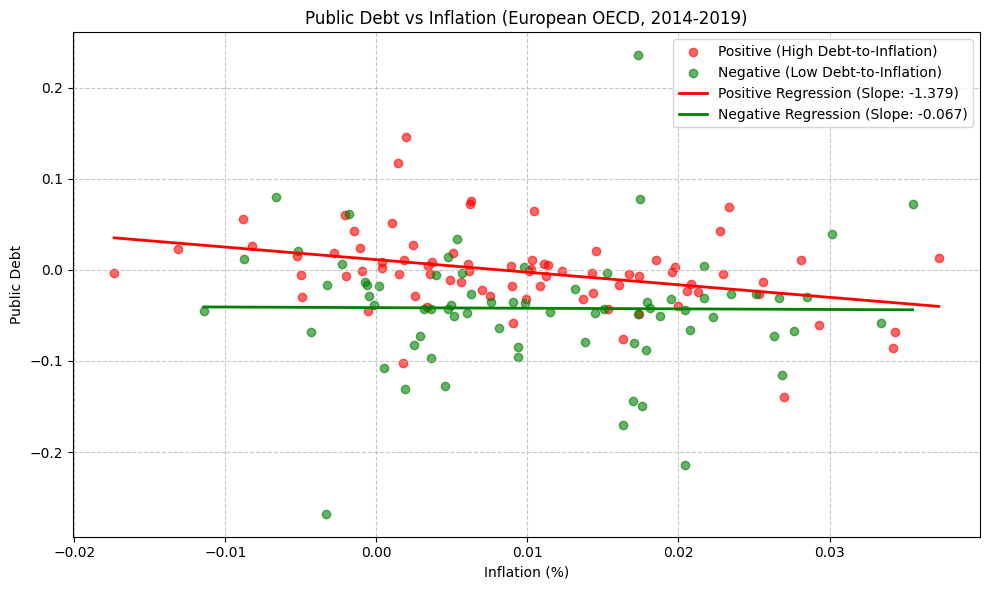

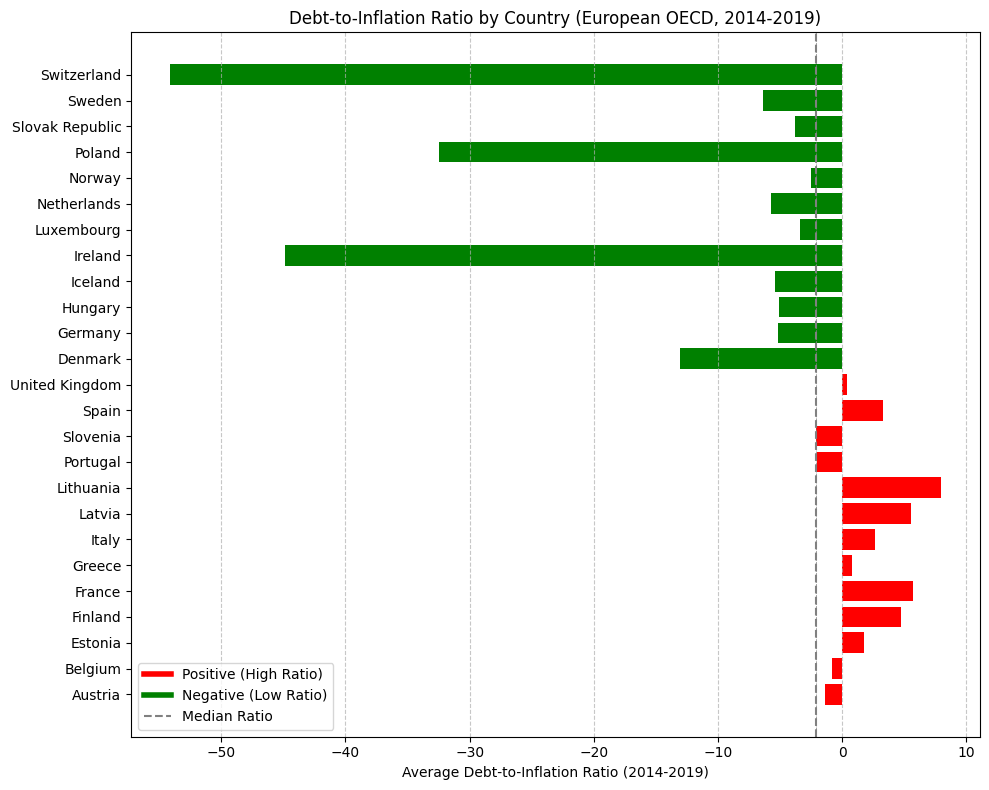


European OECD countries removed due to outliers in Inflation: None
Non-European OECD countries removed due to outliers in Inflation: ['Turkey', 'Colombia', 'Mexico']
Positive European OECD countries (High Debt-to-Inflation): ['Austria', 'Belgium', 'Estonia', 'Finland', 'France', 'Greece', 'Italy', 'Latvia', 'Lithuania', 'Portugal', 'Slovenia', 'Spain', 'United Kingdom']
Negative European OECD countries (Low Debt-to-Inflation): ['Denmark', 'Germany', 'Hungary', 'Iceland', 'Ireland', 'Luxembourg', 'Netherlands', 'Norway', 'Poland', 'Slovak Republic', 'Sweden', 'Switzerland']


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_inflation, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_inflation = df_inflation.melt(id_vars=["Country"], var_name="Year", value_name="Inflation")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_inflation, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Inflation' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Inflation'] = pd.to_numeric(df_long['Inflation'], errors='coerce')

# Filter to 2014-2019
df_2014_2019 = df_long[df_long["Year"].between(2014, 2019)].dropna(subset=["Public_Debt", "Inflation"]).copy()

# IQR function with country tracking (only for Inflation)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Inflation and track removed countries
df_2014_2019_clean, removed_countries_inflation = drop_outliers_iqr(df_2014_2019, "Inflation")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_inflation if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_inflation if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2014_2019_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(european_oecd_countries)]
df_2014_2019_non_european = df_2014_2019_clean[df_2014_2019_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-inflation ratio (average over 2014-2019)
df_2014_2019_european['Debt_to_Inflation'] = df_2014_2019_european["Public_Debt"] / df_2014_2019_european["Inflation"].abs()  # Use absolute value due to potential negatives
median_ratio = df_2014_2019_european.groupby('Country')['Debt_to_Inflation'].mean().median()
european_ratios = df_2014_2019_european.groupby('Country')['Debt_to_Inflation'].mean()
positive_european = european_ratios[european_ratios >= median_ratio].index.tolist()
negative_european = european_ratios[european_ratios < median_ratio].index.tolist()

# Filter European groups
df_positive_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(positive_european)]
df_negative_european = df_2014_2019_european[df_2014_2019_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Inflation"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Positive European OECD countries (High Debt-to-Inflation) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Inflation"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2014-2019):")
    print(f"Coefficient (Inflation): {model_pos.params['Inflation']:.3f}, p-value: {model_pos.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Inflation"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for Negative European OECD countries (Low Debt-to-Inflation) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Inflation"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2014-2019):")
    print(f"Coefficient (Inflation): {model_neg.params['Inflation']:.3f}, p-value: {model_neg.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2014_2019_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2014_2019_non_european["Public_Debt"], df_2014_2019_non_european["Inflation"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2014-2019 Correlation for non-European OECD countries after removing outliers in Inflation: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2014_2019_non_european["Inflation"]
    y_non_eu = df_2014_2019_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2014-2019):")
    print(f"Coefficient (Inflation): {model_non_eu.params['Inflation']:.3f}, p-value: {model_non_eu.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2014-2019 (after removing outliers in Inflation)
if len(df_2014_2019_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2014_2019_clean["Public_Debt"], df_2014_2019_clean["Inflation"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Inflation (2014-2019) after removing outliers in Inflation: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2014_2019_clean["Inflation"]
    y_overall = df_2014_2019_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2014-2019):")
    print(f"Coefficient (Inflation): {model_overall.params['Inflation']:.3f}, p-value: {model_overall.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Visualization 1: Scatter Plot with Regression Lines for European Groups
plt.figure(figsize=(10, 6))
plt.scatter(df_positive_european["Inflation"], df_positive_european["Public_Debt"], color='red', alpha=0.6, label='Positive (High Debt-to-Inflation)')
plt.scatter(df_negative_european["Inflation"], df_negative_european["Public_Debt"], color='green', alpha=0.6, label='Negative (Low Debt-to-Inflation)')

# Regression line for Positive group
if len(df_positive_european) > 2:
    X_pos_range = pd.DataFrame({'const': 1, 'Inflation': [df_positive_european["Inflation"].min(), df_positive_european["Inflation"].max()]})
    y_pos_pred = model_pos.predict(X_pos_range)
    plt.plot(X_pos_range["Inflation"], y_pos_pred, color='red', linewidth=2, label=f'Positive Regression (Slope: {model_pos.params["Inflation"]:.3f})')

# Regression line for Negative group
if len(df_negative_european) > 2:
    X_neg_range = pd.DataFrame({'const': 1, 'Inflation': [df_negative_european["Inflation"].min(), df_negative_european["Inflation"].max()]})
    y_neg_pred = model_neg.predict(X_neg_range)
    plt.plot(X_neg_range["Inflation"], y_neg_pred, color='green', linewidth=2, label=f'Negative Regression (Slope: {model_neg.params["Inflation"]:.3f})')

plt.xlabel("Inflation (%)")
plt.ylabel("Public Debt")
plt.title("Public Debt vs Inflation (European OECD, 2014-2019)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization 2: Bar Chart of Debt-to-Inflation Ratios
plt.figure(figsize=(10, 8))
all_countries = positive_european + negative_european
all_ratios = [european_ratios[country] for country in all_countries]
colors = ['red'] * len(positive_european) + ['green'] * len(negative_european)
bars = plt.barh(all_countries, all_ratios, color=colors)
plt.axvline(x=median_ratio, color='gray', linestyle='--', linewidth=0.5, label=f'Median Ratio: {median_ratio:.2f}')
plt.xlabel("Average Debt-to-Inflation Ratio (2014-2019)")
plt.title("Debt-to-Inflation Ratio by Country (European OECD, 2014-2019)")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.legend([plt.Line2D([0], [0], color='red', lw=4), plt.Line2D([0], [0], color='green', lw=4), plt.axvline(x=median_ratio, color='gray', linestyle='--')],
           ['Positive (High Ratio)', 'Negative (Low Ratio)', 'Median Ratio'])
plt.tight_layout()
plt.show()

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Inflation:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Inflation:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Inflation):", positive_european)
print("Negative European OECD countries (Low Debt-to-Inflation):", negative_european)